In [230]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [231]:
def LIF(I):
    """
    Runs a LIF simulation on neuron and returns outputted voltage

            Parameters:
                    I (double[]): A list of input voltages in mV
                    Cm (double): The membrane capacitance
                    Rm (double): The membrane resistance

            Returns:
                    V (double[]): A list of the output voltages in mV
    """
    V_thresh = 30
    V_rest = -65
    V_spike = 80
    dT = 0.02  # time step in ms
    total_time = (I.size) * dT
    Cm=4
    Rm=5
    
    # an array of time
    time = np.arange(0, total_time, dT)

    # default voltage list set to resting volatage of -65mV
    V = (-65) * np.ones(len(time))
    #V_bin = 0*np.ones(len(time))

    did_spike = False

    # function member variable to track spikes
    spikes = 0

    for t in range(len(time)):
        # using "I - V(t)/Rm = Cm * dV/dT"
        dV = (I[t] - (V[t - 1] - V_rest) / Rm) / Cm

        # reset membrane potential if neuron spiked last tick
        if did_spike:
            V[t] = V_rest + dV * dT
        else:
            V[t] = V[t - 1] + dV * dT

        # check if membrane voltage exceeded threshold (spike)
        if V[t] > V_thresh:
            did_spike = True
            #V_bin[t] = 80
            # set the last step to spike value
            V[t] = V_spike
            spikes += 1
        else:
            did_spike = False
    spike_rate=spikes/100*100
    return V,spikes

In [3]:
def generateSpikeRates(input):
    
    """
    Encodes input into resulting spike rates for all timesteps in a time frame given input current injected 
    Parameters:
        input: Array of inputs at timesteps t
    Returns:
        spike_rate: Array of spiking rates at timesteps t
    """
    t = 100
    dT = .01
    time = np.arange(0, t + dT, dT)
    if isinstance(input, np.integer):
        spike_rate = np.zeros(1)
        I = input*np.ones(len(time))
        V,spikes=LIF(I=I)
        spike_rate[0] = spikes / (time[len(time)-1] - time[0] ) * 100
        return spike_rate
    spike_rate = np.empty(input.size).astype(float)
    for i in range(input.size):
        """calculate spike rate for each iteration"""

        I = input[i]*np.ones(len(time))

        # run LIF simulation
        V,spikes=LIF(I=I)

        # calculate the spike rate during the period
        spike_rate[i] = spikes / (time[len(time)-1] - time[0] ) * 100
        
    return spike_rate

def encodeInputs(inputarray):
    """
    Encodes neuron activity from x and y into rates generated from input current injected at each dT
    Parameters:
        x: Array of binary values representing x
        y: Array of binary values representing y
    Returns:
        x_out: Inputs of x encoded by their corresponding firing rates
        y_out: Inputs of y encoded by their corresponding firing rates
    """
    # example: [1 0 1 0] becomes [107 58 107 58]
    one_curr = 107
    zero_curr = 58

    #encoding for logic
    #inputToCurr = lambda t: zero_curr if t == 0 else (one_curr if t == 1 else -1)
    
    #encoding for black/white
    inputToCurr = lambda t: zero_curr if t <= 7 else (one_curr if t >7  else -1)

    
    out=inputarray
    out=np.multiply(out,one_curr-zero_curr)
    out=np.add(out,zero_curr)
    
    #equation for numbers
    #x_in = np.array([inputToCurr(xi) for xi in inputarray])

    x_out=np.zeros(inputarray.shape)
    #x_out = generateSpikeRates(x_in)
    for i in range(len(x_out)):
        x_out[i]=generateSpikeRates(out[i])
#    y_out = generateSpikeRates(y_in)

    return x_out

In [232]:
def train(inputs,target,epoch,l_rt):
    print("---------------training---------------")
    eout = encodeInputs(inputs)
    teach = encodeInputs(target)
    #inputs=[[0,0], [0,1], [1,0],[1,1]]
    #weights[0] = w_x,out; weights[1] = w_y,out
    weights = 0*np.ones([len(inputs[0])]).astype(float)
    train.accuracy=[]
    for epoch in range(epoch):

#         o_input = np.dot(inputs, weights) # [w_sum1, w_sum2, w_sum3, w_sum4]
        print("epoch: ", epoch)

#         o_out = generateSpikeRates(o_input) #generates spike rates from corresponding input currents calculated for o_input
#         print("output firing rates: \n", o_out)

        for i in range(len(inputs)): 
            for j in range(len(weights)):
                weights[j] += l_rt*eout[i][j]*teach[i] #standard Hebb model modified for perceptrons/teacher neuron => Δw=a*v_pre*(target-v_post)
        print("current weights: ", weights)
        
        #test 1 inputs for accuracy with 30 trials
        num_right=30
        num_wrong=0
        for i in range(num_right):
            test = np.array([random.randint(0,1),random.randint(0,1)])
            #count everytime prediction is wrong
            pred=predict(test, weights, 30)
            num_wrong+=np.abs(target[np.where((inputs == test).all(axis=1))]-pred)  
        print(num_right-num_wrong)
        train.accuracy.append(num_right-num_wrong)
                
    print("------------end training--------------")

    return weights

In [233]:
def predict(input, weights, thresh, one_rt=51, zero_rt=25):
    
    #print("input: ", input)
    
    p_sum = np.dot(input, weights)
    p_rt = generateSpikeRates(np.array([p_sum]))
    
    #zero_lo = zero_rt - thresh
    #zero_hi = zero_rt + thresh
    
    one_lo = one_rt - thresh
    one_hi = one_rt + thresh
    prediction = 0
    if one_lo <= p_rt <= one_hi:
        prediction = 1

    return prediction

In [234]:
x=np.array([[0,0], [0,1], [1,0],[1,1]])
o_teach = np.array([0,1,1,1])
print(encodeInputs(o_teach))
print(encodeInputs(x))
weights = train(x,o_teach,20,0.00055)
# one_curr = 107
# zero_curr = 58
# out=o_teach
# out=np.multiply(out,one_curr-zero_curr)
# out=np.add(out,zero_curr)
# out
#out[1].type
# print(isinstance(out[1], np.integer))

[25. 51. 51. 51.]
[[25. 25.]
 [25. 51.]
 [51. 25.]
 [51. 51.]]
---------------training---------------
epoch:  0
current weights:  [3.9061 3.9061]
[11]
epoch:  1
current weights:  [7.8122 7.8122]
[8]
epoch:  2
current weights:  [11.7183 11.7183]
[9]
epoch:  3
current weights:  [15.6244 15.6244]
[12]
epoch:  4
current weights:  [19.5305 19.5305]
[7]
epoch:  5
current weights:  [23.4366 23.4366]
[8]
epoch:  6
current weights:  [27.3427 27.3427]
[10]
epoch:  7
current weights:  [31.2488 31.2488]
[13]
epoch:  8
current weights:  [35.1549 35.1549]
[18]
epoch:  9
current weights:  [39.061 39.061]
[10]
epoch:  10
current weights:  [42.9671 42.9671]
[16]
epoch:  11
current weights:  [46.8732 46.8732]
[14]
epoch:  12
current weights:  [50.7793 50.7793]
[30]
epoch:  13
current weights:  [54.6854 54.6854]
[30]
epoch:  14
current weights:  [58.5915 58.5915]
[30]
epoch:  15
current weights:  [62.4976 62.4976]
[30]
epoch:  16
current weights:  [66.4037 66.4037]
[30]
epoch:  17
current weights:  [70.3

In [235]:
sample1 = np.array([0,0])
sample2 = np.array([1,0])
sample3 = np.array([0,1])
sample4 = np.array([1,1])
print(predict(sample1, weights, 30),
    predict(sample2, weights, 30),
    predict(sample3, weights, 30),
    predict(sample4, weights, 30))

0 1 1 1


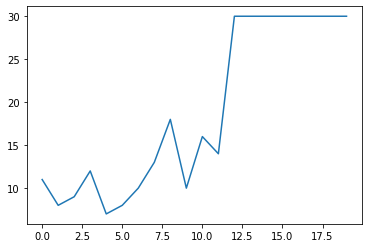

In [236]:
a=np.stack(train.accuracy, axis=0)
b=np.reshape(a, (20))
plt.plot(b)